# Algoritmo de Shor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as mt

from qiskit import *
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram

## Período da função $f(x) = k^x mod N$

In [2]:
# função f(x) periódica
def f(x, k, n):
    return (k ** x) % n

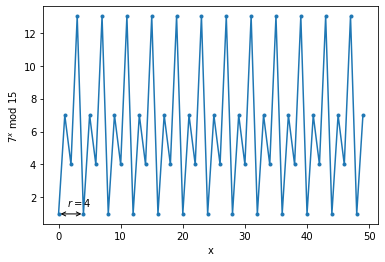

In [3]:
# Gráfico da Função f(x) onde é possível identificar seu período

k = 7
N = 15
num = 50

fx = []

repeticao = False
for x in range(num):
    if (f(x, k, N) == 1) and x != 0 and (not repeticao):
        r = x
        repeticao = True
        
    fx.append(f(x, k, N))

plt.plot(range(num), fx, '.-')
plt.xlabel("x")
plt.ylabel(str(k) + r"$^x$" + " mod " + str(N))
plt.annotate("", xy=(0, 1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
plt.annotate(f'$r={r}$', xy=(r/3, 1.5))
plt.show()

## Protocolo RSA

In [3]:
def algoritmo_euclides(a, b):
    while(b != 0):
        r = a % b
        a = b
        b = r
    return a

def algoritmo_euclides_extendido(a, b):
    """Retorna o MDC(a, b) e os coeficientes x, y tal que a * x + b * y = MDC(a, b)
    para mais detalhes: https://planetcalc.com/3298/
    """
    if a == 0:
        return b, 0, 1
    else:
        g, x, y = algoritmo_euclides_extendido(b%a, a)
        return g, y - (b // a) * x, x

def inverso_multiplicativo(a, m):
    g, x, y = algoritmo_euclides_extendido(a, m)
    
    assert g == 1, "Inverso multiplicativo não existe."
    
    return x % m

def funcao_euler(a, b):
    return (a - 1) * (b - 1)

In [4]:
# Dois números primos a e b
a = 211
b = 223

n = a * b # uma parte da chave pública

phi = funcao_euler(a, b)
print(f"phi = {phi}")

e = 23 # deve ser co-primo de phi

print(f"MDC(e, phi) = {algoritmo_euclides(e, phi)}")

d = inverso_multiplicativo(e, phi)
print(f"d = {d}")

print(f"\nChaves públicas: e = {e} e n = {n}")
print(f"Chaves privadas: d = {d} e n = {n}")

phi = 46620
MDC(e, phi) = 1
d = 2027

Chaves públicas: e = 23 e n = 47053
Chaves privadas: d = 2027 e n = 47053


In [5]:
# Mensagem representada na forma de inteiro
M = 15

print(f"Mensagem M = {M}")

# Mensagem criptografada
C = (M ** e) % n

print(f"Mensagem criptografada C = {C}")

# Mensagem descriptografada
Ml = (C ** d) % n

print(f"Mensagem descriptografada M' = {Ml}")

Mensagem M = 15
Mensagem criptografada C = 32058
Mensagem descriptografada M' = 15


## Determinação Quântica do período de $f(x)$

In [6]:
# Funções para determinação de r a partir dos estados obtidos com a execução do circuito

def fracao_continua(num):
    ai = []
    x = num
    
    a = int(x)
    ai.append(a)
    k = 100
    
    while((x - a) > 1e-7 and k > 0):
        x = 1 / (x - a)
        a = int(x)
        ai.append(a)
        k -= 1
    return ai


def fracao(num):
    ai = fracao_continua(num)[::-1]
    
    c = ai[0]
    b = 1
    
    for a in ai[1:]:
        b = a * c + b        
        b, c = c, b
    b, c = c, b
    
    g = algoritmo_euclides(b, c)

    while (g != 1):
        b //= g
        c //= g
    
    return b, c


def MMC(a, b):
    return (a * b) // algoritmo_euclides(a, b)

In [35]:
# Implementação da Porta U para N = 15

def c_amod15(a, power):
    
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' deve ser coprimo de 15")
        
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    str_power = '{' + str(power) + '}'
    U.name = f"{a}" +r"$^" + f"{str_power}$ mod 15"
    c_U = U.control()
    return c_U

In [8]:
# Implementação da Transformada de Fourrier Inversa

def qft_dagger(n):
    qc = QuantumCircuit(n)
    
    for qubit in range(n // 2):
        qc.swap(qubit, n - 1 - qubit)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi / float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "$QFT^\dagger$"
    return qc

In [20]:
# Variáveis específicas
t = 8  # número de registros
k = 7
N = 15

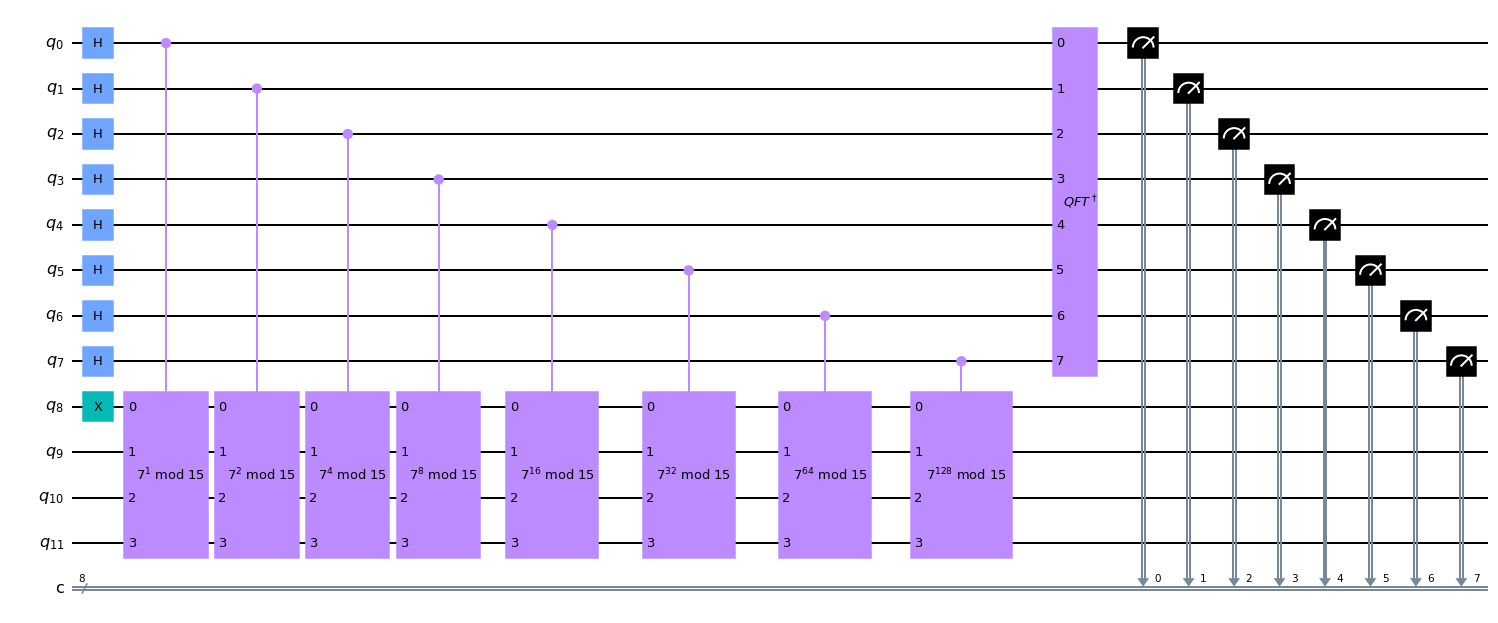

In [36]:
# Circuito que implementa o algoritmo de Shor

qc = QuantumCircuit(t + 4, t)

# Inicializa os t registros no estado uniformemente superposto
for q in range(t):
    qc.h(q)

# Inicia os registros auxiliares no estado |1>
qc.x(t)

# Apricação dos operadores U
for q in range(t):
    qc.append(c_amod15(k, 2**q),
             [q] + [i+ t for i in range(4)])

# Apricação da Transformada de Fourier Inversa
qc.append(qft_dagger(t), range(t))

# Medida do circuito
qc.measure(range(t), range(t))
qc.draw('mpl', fold=-1)  # -1 means 'do not fold'

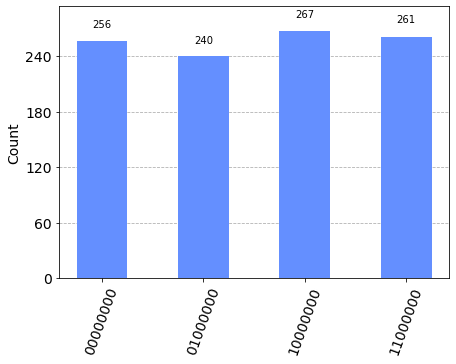

In [12]:
# Execução do circuito

backend = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, backend)
counts = backend.run(t_qc).result().get_counts()
plot_histogram(counts)

In [17]:
# Determinação do período r

fases = []
for estados in counts:
    decimal = int(estados, 2)  
    phase = decimal / (2 ** t)  
    fases.append(phase)

r = 1
for fase in fases:
    b, c = fracao(fase)
    r = MMC(r, c)

print(f"Período de {k}^x mod 15 = {r}")

Período de 7^x mod 15 = 4


In [39]:
# Como r é par podemos encontrar os fatores p1 e p2 de N

p1 = algoritmo_euclides(f(r//2, k, N) - 1, N)
p2 = algoritmo_euclides(f(r//2, k, N) + 1, N)

print(f"Fatores de {N}: {p1} e {p2}")

Fatores de 15: 3 e 5
